# Corpus of Oz Early English (COOEE)

COOEE is a collection of texts produced in Australia between 1788 and 1900. For each of four time periods (1788-1825, 1826-1850, 1851-1875, 1876-1900), the number of tokens included in the corpus is approximately equal. The corpus is also divided into four genres of material (Private Written, Public Written, Government English, Speech-Based) and the proportions of these type of materials is consistent for each time period. This organisation means that the corpus can be stratified into 16 sections to see whether linguistic features vary according to either or both of the variables.

This notebook illustrates how the corpus can be accessed via the Language Data Commons of Australia API and then how the downloaded data can be reconfigured as a flat tabular structure which makes the metadata variables easy to access. The notebook also demonstrates one way to split the data into 16 stratified sub-corpora which are then used as the basis for topic modeling. The final result is that we can make a visualisation showing what topics are more or less strongly associated with particular sub-corpora.

In [1]:
# Import libraries

import os                                                  # Functions for interacting with the operating system.
import zipfile                                             # Tools to create, read, write, append and list a ZIP file.
import requests                                            # Send HTTP requests.
from io import BytesIO                                     # Perform file operations on byte data.
from rocrate_tabular.tabulator import ROCrateTabulator     # Python library to turn an RO-Crate into tabular formats.

In [2]:
# Enable in-notebook visualizations
%matplotlib inline

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [3]:
# Specify the names of the database and corpus download folder to be created, or leave as the defaults.

database = 'cooee.db'     # Edit the section in quotes to rename the database.
folder = 'cooee'       # Edit the section in quotes to rename the folder that is created for the data download.

# Download and tabulation

We will download the whole COOEE dataset and use [RO-Crate tabulator](https://github.com/Sydney-Informatics-Hub/rocrate-tabular) to create a table which includes both text data and metadata.

Download the COOEE collection ZIP from the LDaCA data portal and extract it to a folder in the current working directory.

In [4]:
zip_url = "https://data.ldaca.edu.au/api/object/arcp%3A%2F%2Fname%2Chdl10.26180~23961609.zip"
cwd = os.getcwd()
extract_to = os.path.join(cwd, folder)
os.makedirs(extract_to, exist_ok=True)
response = requests.get(zip_url, stream=True)
response.raise_for_status()
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_to)

Convert the RO-Crate to a database. Arguments specified are the RO-Crate directory and the output name of the database.

In [5]:
tb = ROCrateTabulator()
tb.crate_to_db(folder, database)

100%|████████████████████████████████████████████████████████████| 8078/8078 [00:07<00:00, 1080.35it/s]


<Database <sqlite3.Connection object at 0x107fb7970>>

`tb.infer_config()` returns help text to tell you what potential tables are available to you.

In [6]:
tb.infer_config()


Potential tables:
CreativeWork, Person, Organization, Book, Dataset, ldac:DataReuseLicense, File, ldac:CollectionProtocol, WebPage, Standard, Place, rdf:Property, DefinedTermSet, RepositoryCollection, DefinedTerm, Language, Geometry, RepositoryObject, PeopleAudience, SoftwareSourceCode, CreateAction

To create your tables run: (example code, replace with your desired tables)
```python
tb.use_tables(["CreativeWork", "Person"])
```


For our analysis we only need a `RepositoryObject` table. A `RepositoryObject` is a type of abstract entity which contains the metadata for a single "item" in the COOEE collection (i.e., a single text, including all files associated with it).

In [7]:
tb.use_tables(["RepositoryObject"])

100%|█████████████████████████████████████████████████████████████| 1354/1354 [00:11<00:00, 118.82it/s]


### Properties
<details><summary>RepositoryObject</summary><ul><li><code>register</code></li><li><code>textType</code></li><li><code>author</code></li><li><code>conformsTo</code></li><li><code>ldac:communicationMode</code></li><li><code>citation</code></li><li><code>inLanguage</code></li><li><code>@type</code></li><li><code>datePublished</code></li><li><code>description</code></li><li><code>name</code></li><li><code>identifier</code></li><li><code>hasPart</code></li><li><code>locationCreated</code></li><li><code>ldac:mainText</code></li><li><code>dateCreated</code></li><li><code>temporal</code></li><li><code>ldac:linguisticGenre</code></li><li><code>ldac:indexableText</code></li><li><code>recipient</code></li></ul></details>


To attempt to expand references from a particular property
and bring the values from linked entities into the primary
table as columns: (example code, replace with your desired table and properties)

```python
tb.expand_properties("CreativeWork", ["author"])
```

To exlude a property from the table:

```python
tb.ignore_properties("CreativeWork", ["datePublished"])
```
        

For our analysis we don't need to expand or ignore any properties, so we'll continue onto building the table. The following code will call `tb.entity_table` for each table that was passed to `tb.use_tables`.

In [8]:
for table in tb.config["tables"]:
    print(f"Building entity table for {table}")
    tb.entity_table(table, 'ldac:indexableText')

Building entity table for RepositoryObject


100%|█████████████████████████████████████████████████████████████| 1354/1354 [00:11<00:00, 114.42it/s]


# Data preparation

In [9]:
import sqlite3
import pandas as pd

with sqlite3.connect(database) as conn:
    query = "SELECT * FROM RepositoryObject"  # Replace with your table name if not using RepositoryObject
    df = pd.read_sql(query, conn)

# parse date into number
df['dateCreated'] = pd.to_datetime(df['dateCreated']).dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   entity_id                  1354 non-null   object
 1   @type                      1354 non-null   object
 2   conformsTo                 1354 non-null   object
 3   conformsTo_id              1354 non-null   object
 4   identifier                 1354 non-null   object
 5   name                       1354 non-null   object
 6   author                     1354 non-null   object
 7   author_id                  1354 non-null   object
 8   description                1354 non-null   object
 9   dateCreated                1354 non-null   int32 
 10  register                   1354 non-null   object
 11  register_id                1354 non-null   object
 12  textType                   1354 non-null   object
 13  textType_id                1354 non-null   object
 14  temporal

After reading the Tabulator database into pandas we get the metadata in tabular form, alongside the text data in the `ldac:indexableText` column. (pandas is a Python library for handling tabular data.)

## Stratify data

The following code slices the data by register and time period and concatenates the text of each document within a slice to create 16 large documents. The output for this cell tracks how many of the text fragments in COOEE are included in each of the slices.

In [10]:
registers = pd.DataFrame(
    [
        ("Government English", "ge"),
        ("Private Written", "prw"),
        ("Public Written", "puw"),
        ("Speech Based", "sb")
    ],
    columns=["full", "short"]
)

time_periods = pd.DataFrame(
    [
        (1, 1788, 1825),
        (2, 1826, 1850),
        (3, 1851, 1875),
        (4, 1876, 1900)
    ],
    columns=["period", "start", "end"]
)

In [11]:
# make list of titles for slices and list with combined texts for each slice
sub_titles = []
documents = []

for i in range(0, 4):
    for j in range(0, 4):
        sub_title = f"{registers.loc[i, 'short']}_period{time_periods.loc[j, 'period']}"
        sub_titles.append(sub_title)
            
        # Filter `cooee` DataFrame based on conditions
        temp = df.loc[
            (df["register"] == registers.loc[i, 'full']) & 
            (df["dateCreated"] >= time_periods.loc[j, 'start']) &
            (df["dateCreated"] <= time_periods.loc[j, 'end'])
        ]
        print(len(temp))

        # export indexableText to list
        texts = temp['ldac:indexableText'].values.tolist()

        # combine indexableText as single document        
        documents.append(' '.join(texts))


52
54
41
48
99
130
120
258
71
145
99
90
43
35
46
23


## Cleaning, tokenization, lemmatization

As input for the topic modeling algorithm, we need each document we are analysing to be a list of words. The code that follows carries out various operations to reach that point. Some words and other items in the text can be considered as 'noise' for the analysis and these are removed: punctuation marks, numbers, artefacts of digital text such as new line symbols and many common words which are not relevant for the analysis (e.g. *the*, *and* and *of*). The first cell below defines functions to carry out the cleaning and the second cell executes those functions - this includes assigning part-of-speech tags to words and therefore executing this cell may take a little time.

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tag.perceptron import PerceptronTagger
import re

punctuation = u",.?!()-_\"\'\\\n\r\t;:+*<>@#§^$%&|/"
stop_words_eng = set(stopwords.words('english'))
# add to stop list: apostrophe-s, non-standard quotation marks, 'would'
stop_words_eng.update(["'s", "``", "would", "''", "one" ])
lemmatizer = WordNetLemmatizer()
tag_dict = {"J": wn.ADJ,
            "N": wn.NOUN,
            "V": wn.VERB,
            "R": wn.ADV}

def extract_wnpostag_from_postag(tag):
    #take the first letter of the tag
    #the second parameter is an "optional" in case of missing key in the dictionary 
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tuple_word_postag(tup):
    """
    given a tuple of the form (wordString, posTagString) like ('guitar', 'NN'), return the lemmatized word
    """
    tag = extract_wnpostag_from_postag(tup[1])    
    return lemmatizer.lemmatize(tup[0], tag) if tag is not None else tup[0]

def bag_of_words(sentence, stop_words=None):
    if stop_words is None:
        stop_words = stop_words_eng
    original_words = word_tokenize(sentence)
    lower_case = [word.lower() for word in original_words]
    tagged_words = nltk.pos_tag(lower_case) #returns a list of tuples: (word, tagString) like ('And', 'CC')
    original_words = None
    lemmatized_words = [ lemmatize_tuple_word_postag(ow) for ow in tagged_words ]
    tagged_words = None
    cleaned_words = [ w for w in lemmatized_words if (w not in punctuation) and (w not in stop_words) ]
    lemmatized_words = None
    no_numbers = [re.sub(r'\w*\d\w*', '', w) for w in cleaned_words]
    return no_numbers
            
def clean_document(text):
    text = text.replace('\n', ' ')
    text = text.replace('\\', ' ')
    # change 'd to ed (e.g., "six-oar'd cutter" to "six-oared")
    text = re.sub(r"(\w)'d(\s|$)", r"\1ed\2", text) 
    cleaned_tokens = bag_of_words(text)
    return [word for word in cleaned_tokens if word.isalpha()]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [13]:
clean_documents = [clean_document(doc) for doc in documents]

# Model training

We are using here an approach to topic modeling called Latent Dirichlet Allocation (LDA). LDA is an algorithm which, given a set of documents and a specified number of topics, returns a model which has two parts: a distribution of the probability of each word being associated with each topic and a distribution of the probability of each document being associated with each topic. LDA modeling is a Bayesian procedure, that is, iterative processing improves the accuracy of the model. The code below specifies 100 passes for modeling and as you will see, this can take a few minutes.

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [15]:
dictionary = Dictionary(clean_documents)

corpus = [dictionary.doc2bow(doc) for doc in clean_documents]

In [16]:
lda_model = LdaMulticore(
    corpus,
    id2word=dictionary,
    random_state=100,
    num_topics=10,
    passes=100
)

LDAvis is an interactive visualisation for LDA topic modelling. The topics are numbered by size, with "1" being the largest topic, but these numbers do not match the "Topic 1" naming in the rest of this notebook.

Hover or click a topic circle to select it. Hover over a word in the terms list to see its conditional distribution over the topics.

Lowering the value of lambda will adjust how relevance is calculated, surfacing terms that are more strongly associated with the selected topic. A full description of this can be found in the LDAvis paper.

- Topic circle: size represents proportion of topic across the entire corpus, similar topics will be closer together
- Blue bars: frequency of term in corpus
- Red bar (only visible when a topic circle is selected): Estimated number of times the word was generated by the selected topic

More information: [LDAvis: A method for visualizing and interpreting topics](https://aclanthology.org/W14-3110/) (Sievert & Shirley, 2014)

In [17]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')

/Users/uqrsmi33/repo/github.com/r-tae/cooee/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.050969  0.099110       1        1  27.704852
0     -0.026944  0.228761       2        1  24.405619
8      0.125676  0.154339       3        1  23.948656
2      0.286212  0.073975       4        1   8.941371
3      0.040448  0.198268       5        1   8.740976
1      0.222768 -0.062165       6        1   6.257818
4     -0.174782 -0.173072       7        1   0.000177
6     -0.174782 -0.173072       8        1   0.000177
7     -0.174782 -0.173072       9        1   0.000177
9     -0.174782 -0.173072      10        1   0.000177, topic_info=        Term        Freq        Total Category  logprob  loglift
693    court  2259.00000  2259.000000  Default  30.0000  30.0000
2744   shall  3181.00000  3181.000000  Default  29.0000  29.0000
532   colony  2673.00000  2673.000000  Default  28.0000  28.0000
2672     say  4973.00000  4973.000000  Default  27.0000  27.0000
1898     may  3390.00000  3390.000000  Default  26.0000  26.0000
...      ...         ...          ...      ...      ...      ...
3056   three     0.00005  1759.304308  Topic10 -10.3846  -4.1379
3044   think     0.00005  2574.518004  Topic10 -10.3846  -4.5186
2230   place     0.00005  2568.008851  Topic10 -10.3846  -4.5161
1376   great     0.00005  2975.691078  Topic10 -10.3846  -4.6635
1753    last     0.00005  1954.813072  Topic10 -10.3846  -4.2433

[794 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
45        1  0.116588   act
45        2  0.069277   act
45        3  0.152916   act
45        4  0.594767   act
45        5  0.015207   act
...     ...       ...   ...
3375      2  0.275906  year
3375      3  0.196681  year
3375      4  0.115614  year
3375      5  0.055273  year
3375      6  0.069552  year

[1383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 9, 3, 4, 2, 5, 7, 8, 10])

It was mentioned above that one part of an LDA model associated words with topics. The usual way to use this information is to examine some number of the words most strongly associated with each topic and to see whether this suggests some plausible semantic grouping. The next code cell prepares and presents a display of the ten words most strongly associated with each of our ten topics. As you will see, in some cases we might feel able to assign some sort of label to these groups of words, but in other cases it doesn't really make sense to do that. Therefore we will use the top three words from each topic as labels for the next visualisation.

In [18]:
# make tabular display of top 10 words for each topic

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])

# top_words_per_topic
top_words = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])

# tabular display
topics_table = pd.DataFrame()
for i in range(0,lda_model.num_topics):
    col_name = "Topic" + str(i+1)
    temp = top_words.loc[(top_words["Topic"] == i)]
    temp_words = temp["Word"].to_list()
    topics_table[col_name] = temp_words
topics_table

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,mile,colony,shall,day,make,say,day,go,make,get
1,get,state,court,go,say,go,go,say,take,mile
2,go,may,say,us,time,come,us,good,time,come
3,water,new,may,make,take,make,make,come,upon,water
4,good,member,colony,take,go,take,say,make,find,go
5,come,power,act,come,come,man,time,time,two,day
6,day,south,law,great,great,time,take,day,day,make
7,well,say,person,ship,may,day,get,two,prisoner,say
8,find,question,time,time,good,upon,come,could,could,find
9,see,make,majesty,much,man,know,country,take,great,take


In [19]:
topic_names = []

for i in range(0,lda_model.num_topics):
    topic_name = f"Topic{str(i)} {topics_table.iloc[1, i]} {topics_table.iloc[2, i]}  {topics_table.iloc[3, i]}"
    topic_names.append(topic_name)

## Preparing for visualisation

We now turn to the second part of the model. We are interested to see which topics are associated with which sub-corpora or to put it in more everyday words, were people writing about the same things or different things depending on the time and type of text? The basis for the visualisation is a table showing the association weight for each topic in each document (where a document is a sub-corpus from the stratification).

In [20]:
# get weightings for each document

doc_weights = []

for doc in clean_documents:
    bow = dictionary.doc2bow(doc)
    t = lda_model.get_document_topics(bow, minimum_probability=0)
    doc_weights.append(t)

# drop document numbers from weights list
weights = []

for doc_row in doc_weights:

    out = []

    for item in doc_row:
        weight = item[1]
        out.append(weight)
    weights.append(out)
weights

[[5.08176e-06,
  5.0817494e-06,
  0.6047525,
  0.09652157,
  5.0804965e-06,
  5.081674e-06,
  5.0804965e-06,
  5.0804965e-06,
  0.2986904,
  5.0804965e-06],
 [0.0063259355,
  0.00020833017,
  0.9456478,
  3.4393946e-05,
  4.0591667e-06,
  0.00070942333,
  4.0591667e-06,
  4.0591667e-06,
  0.047057964,
  4.0591667e-06],
 [4.0121945e-06,
  0.1978607,
  0.8018916,
  4.0120262e-06,
  4.0111254e-06,
  4.012191e-06,
  4.0111254e-06,
  4.0111254e-06,
  0.00021960364,
  4.0111254e-06],
 [4.1587687e-06,
  0.41741344,
  0.58255327,
  4.1587714e-06,
  4.1579524e-06,
  4.1588164e-06,
  4.1579524e-06,
  4.1579524e-06,
  4.158859e-06,
  4.1579524e-06],
 [0.16657169,
  1.2694179e-06,
  8.495072e-05,
  0.79680735,
  1.2691023e-06,
  0.0034477375,
  1.2691023e-06,
  1.2691023e-06,
  0.03308191,
  1.2691023e-06],
 [0.5917874,
  1.28426e-06,
  0.0005585267,
  0.027812026,
  1.2839383e-06,
  0.13622148,
  1.2839383e-06,
  1.2839383e-06,
  0.24361414,
  1.2839383e-06],
 [0.98572636,
  1.261379e-06,
  0.001

In [21]:
# massage data to be input for visualisation
topic_df = (pd.DataFrame(weights, columns=topic_names))

topics_transpose = topic_df.transpose()
topics_transpose.columns = sub_titles       

topics_transpose

,ge_period1,ge_period2,ge_period3,ge_period4,prw_period1,prw_period2,prw_period3,prw_period4,puw_period1,puw_period2,puw_period3,puw_period4,sb_period1,sb_period2,sb_period3,sb_period4
Topic0 get go water,0.000005,0.006326,0.000004,0.000004,0.166572,0.591787,0.985726,0.999784,0.000733,0.054313,0.024934,0.001403,0.000003,0.001076,0.000049,0.008967
Topic1 state may new,0.000005,0.000208,0.197861,0.417413,0.000001,0.000001,0.000001,0.000001,0.000001,0.000108,0.000711,0.001729,0.000003,0.002658,0.464213,0.854972
Topic2 court say may,0.604752,0.945648,0.801892,0.582553,0.000085,0.000559,0.001048,0.000001,0.000258,0.005619,0.001216,0.000091,0.241174,0.069781,0.013832,0.000010
Topic3 go us make,0.096522,0.000034,0.000004,0.000004,0.796807,0.027812,0.000074,0.000001,0.000048,0.006751,0.000042,0.000001,0.283891,0.000003,0.000003,0.059667
Topic4 say time take,0.000005,0.000004,0.000004,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000003,0.000003
Topic5 go come make,0.000005,0.000709,0.000004,0.000004,0.003448,0.136221,0.002214,0.000206,0.000248,0.551627,0.834547,0.996161,0.000111,0.030211,0.499258,0.072752
Topic6 go us make,0.000005,0.000004,0.000004,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000003,0.000003
Topic7 say good come,0.000005,0.000004,0.000004,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000003,0.000003
Topic8 take time upon,0.298690,0.047058,0.000220,0.000004,0.033082,0.243614,0.010930,0.000001,0.998708,0.381577,0.138546,0.000611,0.474807,0.896259,0.022633,0.003619
Topic9 mile come water,0.000005,0.000004,0.000004,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000003,0.000003


# Visualization

A heat map is an effective visualisation for this kind of information and we can create one easily using existing Python libraries.

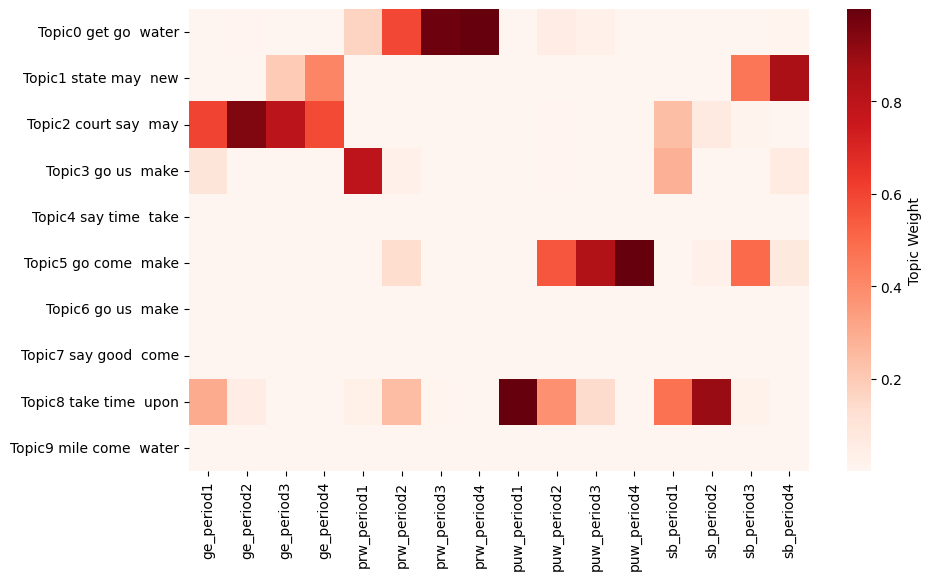

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.figure(figsize=(10, 6))  # Adjust the width and height
sns.heatmap(topics_transpose, 
            cmap='Reds',  # 'Reds' colormap corresponds to the red color scheme
            cbar_kws={'label': 'Topic Weight'},  # Color bar label
            linewidths=0,  # No lines between cells
            xticklabels=True,  # Show column labels
            yticklabels=True,  # Show row labels
            square=False,  # To avoid forcing the aspect ratio to be square
            cbar=True)  # Display color bar

# Rotate column labels
plt.xticks(rotation=90)

plt.show()

**Registers**
- `ge`: Government English
- `prw`: Private Written
- `puw`: Public Written
- `sb`: Speech-based

**Time periods**
- Period 1: 1788-1825
- Period 2: 1826-1859
- Period 3: 1851-1875
- Period 4: 1876-1900